# Bike Sharing Demand — Exploratory Data Analysis

| Item | Detail |
|------|--------|
| **Dataset** | Hourly bike rental demand (2011–2012) |
| **Target** | `cnt` — total rental count per hour |
| **Goal** | Understand data quality, distributions, relationships, and identify features for regression modeling |

In [12]:
import warnings, os
warnings.filterwarnings("ignore")
os.environ.setdefault("MPLCONFIGDIR", "/tmp/matplotlib-cache")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
plt.rcParams.update({"figure.dpi": 110, "axes.titlesize": 13, "axes.labelsize": 11})

FIGSIZE      = (14, 5)
FIGSIZE_WIDE = (16, 5)
PALETTE      = sns.color_palette("muted")

In [13]:
df = pd.read_csv("../data/bike_sharing.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [15]:
df = pd.read_csv("../data/bike_sharing.csv", parse_dates=["dteday"])

TARGET       = "cnt"
LEAKAGE      = ["instant", "dteday", "casual", "registered"]
NUMERIC      = ["temp", "atemp", "hum", "windspeed"]
ORDINAL      = ["hr", "mnth", "weekday"]
CATEGORICAL  = ["season", "yr", "holiday", "workingday", "weathersit"]

SEASON_MAP   = {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}
WEATHER_MAP  = {1: "Clear", 2: "Mist/Cloudy", 3: "Light Rain/Snow", 4: "Heavy Rain/Snow"}

print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Period: {df['dteday'].min().date()} → {df['dteday'].max().date()}")
df.head()

Shape: 17,379 rows × 17 columns
Period: 2011-01-01 → 2012-12-31


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


---
## 1 — Data Quality Check

In [16]:
quality = pd.DataFrame({
    "dtype":       df.dtypes.astype(str),
    "missing":     df.isnull().sum(),
    "missing_pct": (df.isnull().mean() * 100).round(2),
    "unique":      df.nunique(),
    "example":     df.iloc[0]
})
quality

,dtype,missing,missing_pct,unique,example
instant,int64,0,0.0,17379,1
dteday,datetime64[ns],0,0.0,731,2011-01-01 00:00:00
season,int64,0,0.0,4,1
yr,int64,0,0.0,2,0
mnth,int64,0,0.0,12,1
hr,int64,0,0.0,24,0
holiday,int64,0,0.0,2,0
weekday,int64,0,0.0,7,6
workingday,int64,0,0.0,2,0
weathersit,int64,0,0.0,4,1


In [17]:
n_duplicates = df.duplicated().sum()
print(f"Duplicate rows : {n_duplicates}")
print(f"Missing values : {df.isnull().sum().sum()}")
print("\n→ Dataset is clean — no imputation or deduplication needed.")

Duplicate rows : 0
Missing values : 0

→ Dataset is clean — no imputation or deduplication needed.


---
## 2 — Descriptive Statistics

In [18]:
desc = df[NUMERIC + ORDINAL + [TARGET]].describe().T
desc["skew"]     = df[NUMERIC + ORDINAL + [TARGET]].skew()
desc["kurtosis"] = df[NUMERIC + ORDINAL + [TARGET]].kurtosis()
desc.round(3)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
temp,17379.0,0.497,0.193,0.02,0.340,0.500,0.660,1.000,-0.006,-0.942
atemp,17379.0,0.476,0.172,0.00,0.333,0.485,0.621,1.000,-0.090,-0.845
hum,17379.0,0.627,0.193,0.00,0.480,0.630,0.780,1.000,-0.111,-0.826
windspeed,17379.0,0.190,0.122,0.00,0.104,0.194,0.254,0.851,0.575,0.591
hr,17379.0,11.547,6.914,0.00,6.000,12.000,18.000,23.000,-0.011,-1.198
mnth,17379.0,6.538,3.439,1.00,4.000,7.000,10.000,12.000,-0.009,-1.202
weekday,17379.0,3.004,2.006,0.00,1.000,3.000,5.000,6.000,-0.003,-1.256
cnt,17379.0,189.463,181.388,1.00,40.000,142.000,281.000,977.000,1.277,1.417


---
## 3 — Target Variable (`cnt`)

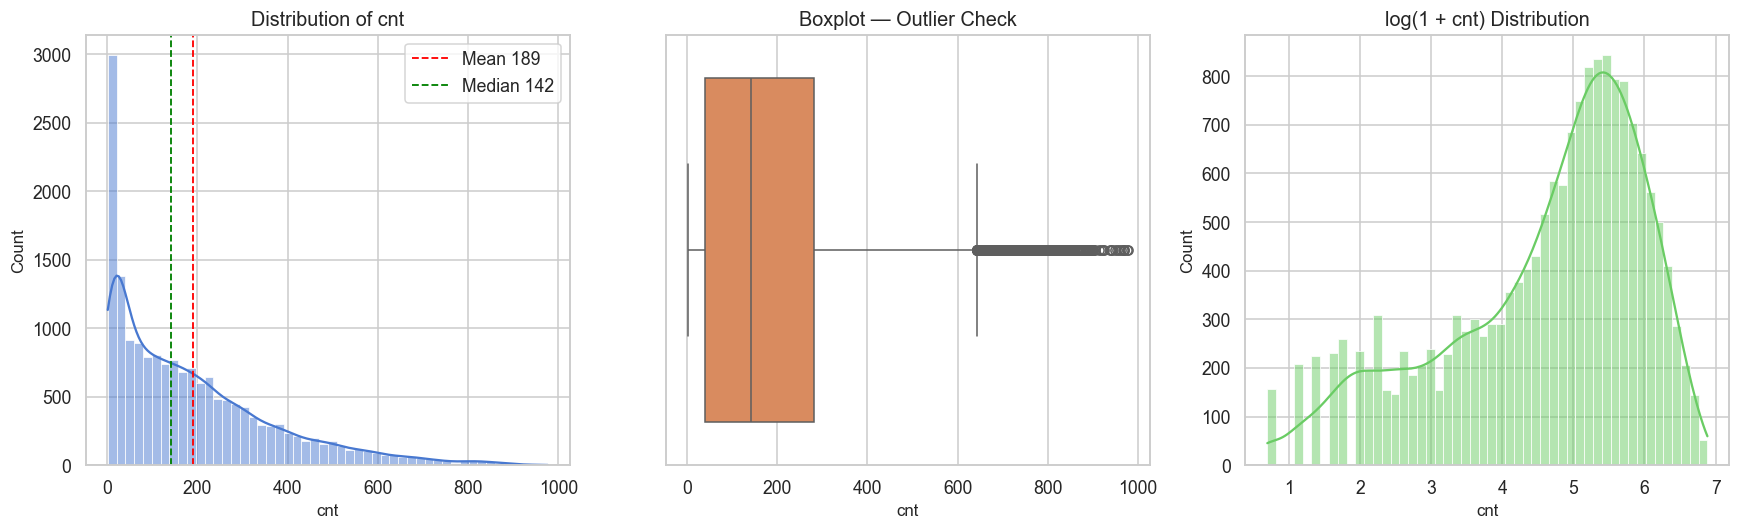

Skewness : 1.277  (right-skewed)
Kurtosis : 1.417
→ Log transform improves normality — consider for linear models.


In [6]:
fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_WIDE)

# 3a  Distribution
sns.histplot(df[TARGET], bins=50, kde=True, ax=axes[0], color=PALETTE[0])
axes[0].axvline(df[TARGET].mean(),   color="red",   ls="--", lw=1.2, label=f"Mean {df[TARGET].mean():.0f}")
axes[0].axvline(df[TARGET].median(), color="green", ls="--", lw=1.2, label=f"Median {df[TARGET].median():.0f}")
axes[0].legend()
axes[0].set_title("Distribution of cnt")

# 3b  Boxplot
sns.boxplot(x=df[TARGET], ax=axes[1], color=PALETTE[1])
axes[1].set_title("Boxplot — Outlier Check")

# 3c  Log-transformed
sns.histplot(np.log1p(df[TARGET]), bins=50, kde=True, ax=axes[2], color=PALETTE[2])
axes[2].set_title("log(1 + cnt) Distribution")

plt.tight_layout()
plt.show()

print(f"Skewness : {df[TARGET].skew():.3f}  (right-skewed)")
print(f"Kurtosis : {df[TARGET].kurtosis():.3f}")
print("→ Log transform improves normality — consider for linear models.")

---
## 4 — Univariate Analysis

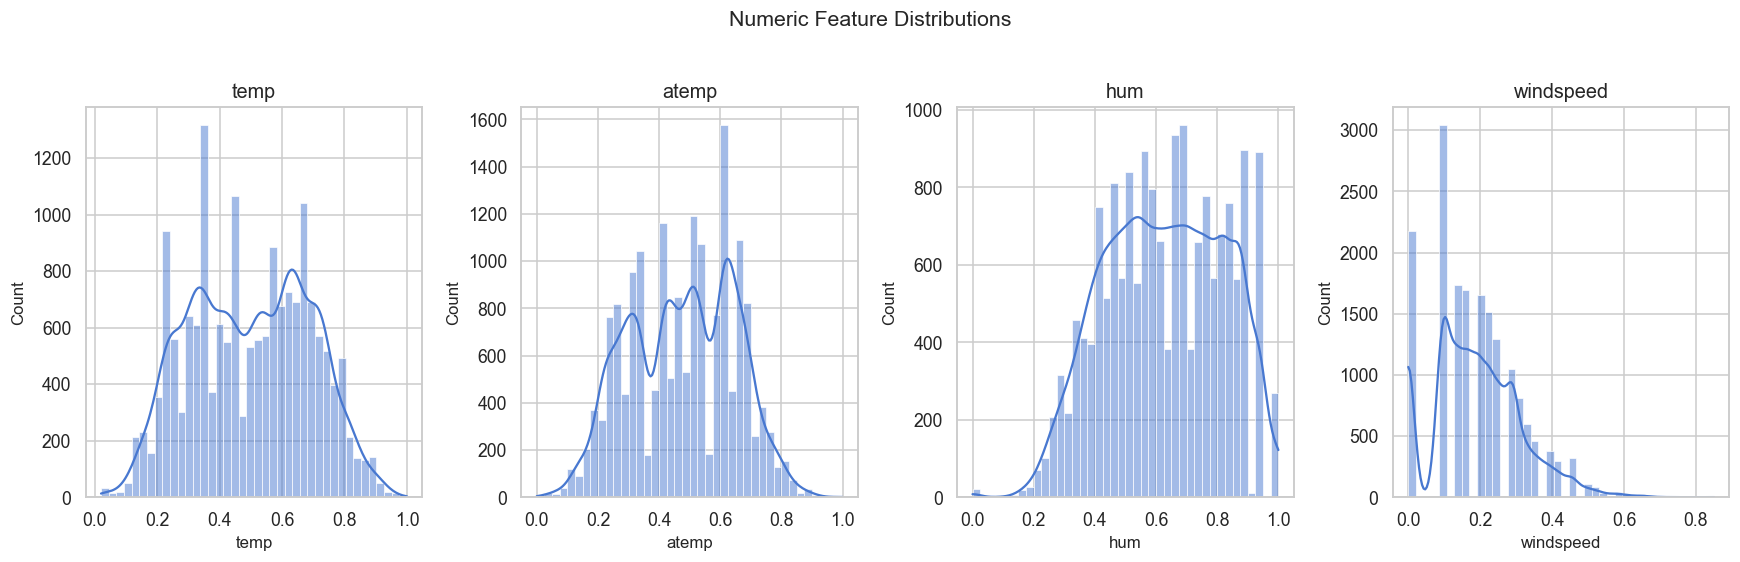

In [7]:
# 4a  Numeric feature distributions
fig, axes = plt.subplots(1, len(NUMERIC), figsize=FIGSIZE_WIDE)
for ax, col in zip(axes, NUMERIC):
    sns.histplot(df[col], bins=40, kde=True, ax=ax, color=PALETTE[0])
    ax.set_title(col)
plt.suptitle("Numeric Feature Distributions", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

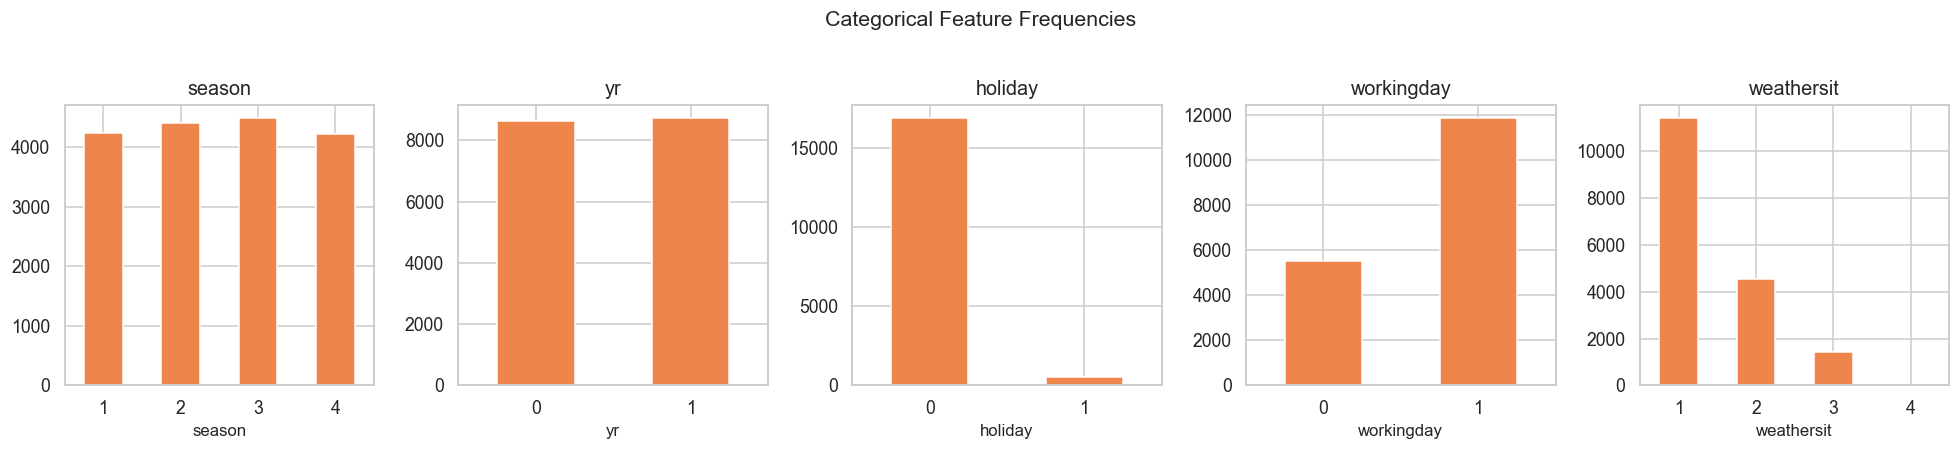

In [8]:
# 4b  Categorical feature value counts
fig, axes = plt.subplots(1, len(CATEGORICAL), figsize=(18, 4))
for ax, col in zip(axes, CATEGORICAL):
    counts = df[col].value_counts().sort_index()
    counts.plot.bar(ax=ax, color=PALETTE[1], edgecolor="white")
    ax.set_title(col)
    ax.tick_params(axis="x", rotation=0)
plt.suptitle("Categorical Feature Frequencies", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

---
## 5 — Bivariate Analysis: Features vs Target

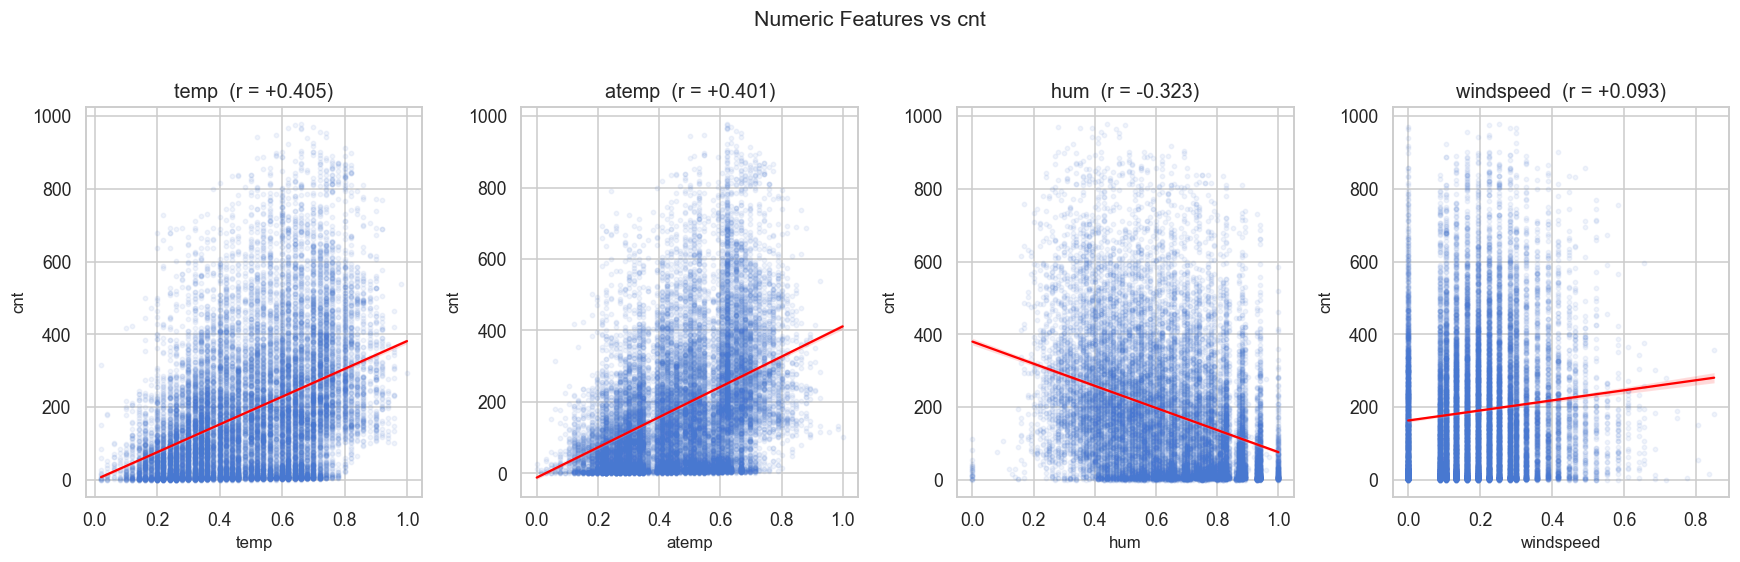

In [9]:
# 5a  Numeric features vs target (scatter + regression line)
fig, axes = plt.subplots(1, len(NUMERIC), figsize=FIGSIZE_WIDE)
for ax, col in zip(axes, NUMERIC):
    sns.regplot(data=df, x=col, y=TARGET, ax=ax,
                scatter_kws={"alpha": 0.08, "s": 8}, line_kws={"color": "red", "lw": 1.5})
    r = df[col].corr(df[TARGET])
    ax.set_title(f"{col}  (r = {r:+.3f})")
plt.suptitle("Numeric Features vs cnt", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

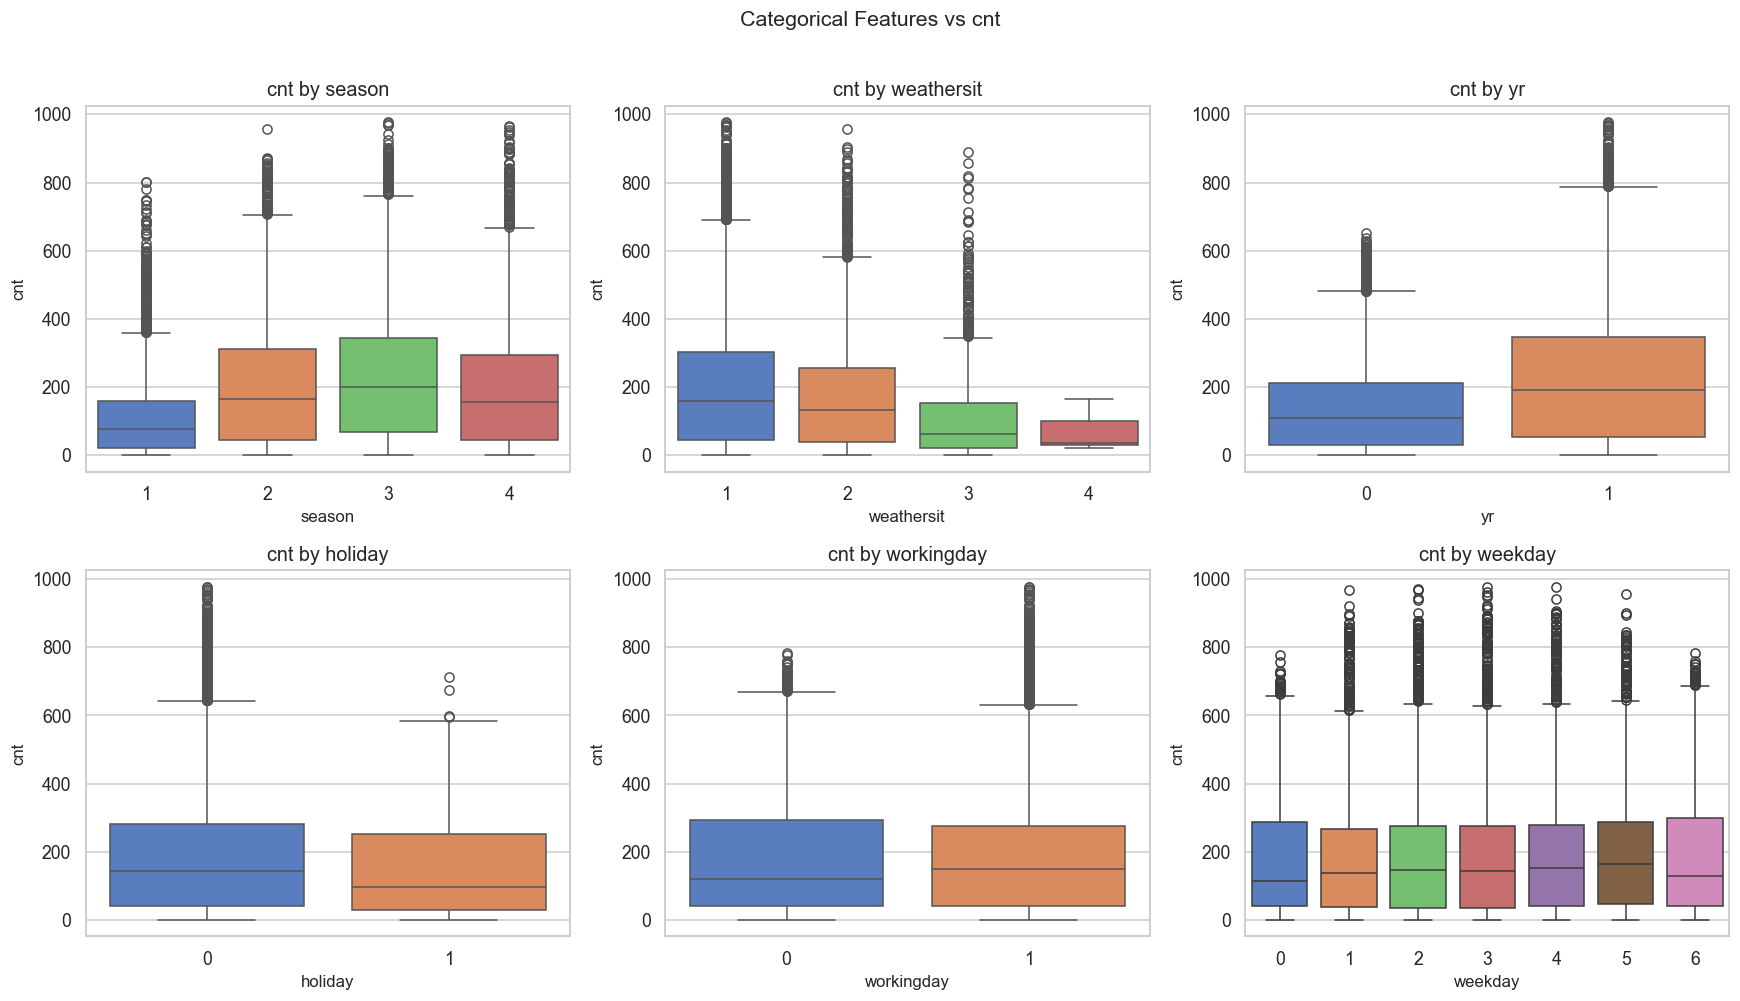

In [10]:
# 5b  Categorical / ordinal features vs target (boxplots)
cat_cols = ["season", "weathersit", "yr", "holiday", "workingday", "weekday"]
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for ax, col in zip(axes.flat, cat_cols):
    sns.boxplot(data=df, x=col, y=TARGET, ax=ax, palette="muted")
    ax.set_title(f"{TARGET} by {col}")
plt.suptitle("Categorical Features vs cnt", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

---
## 6 — Temporal Patterns

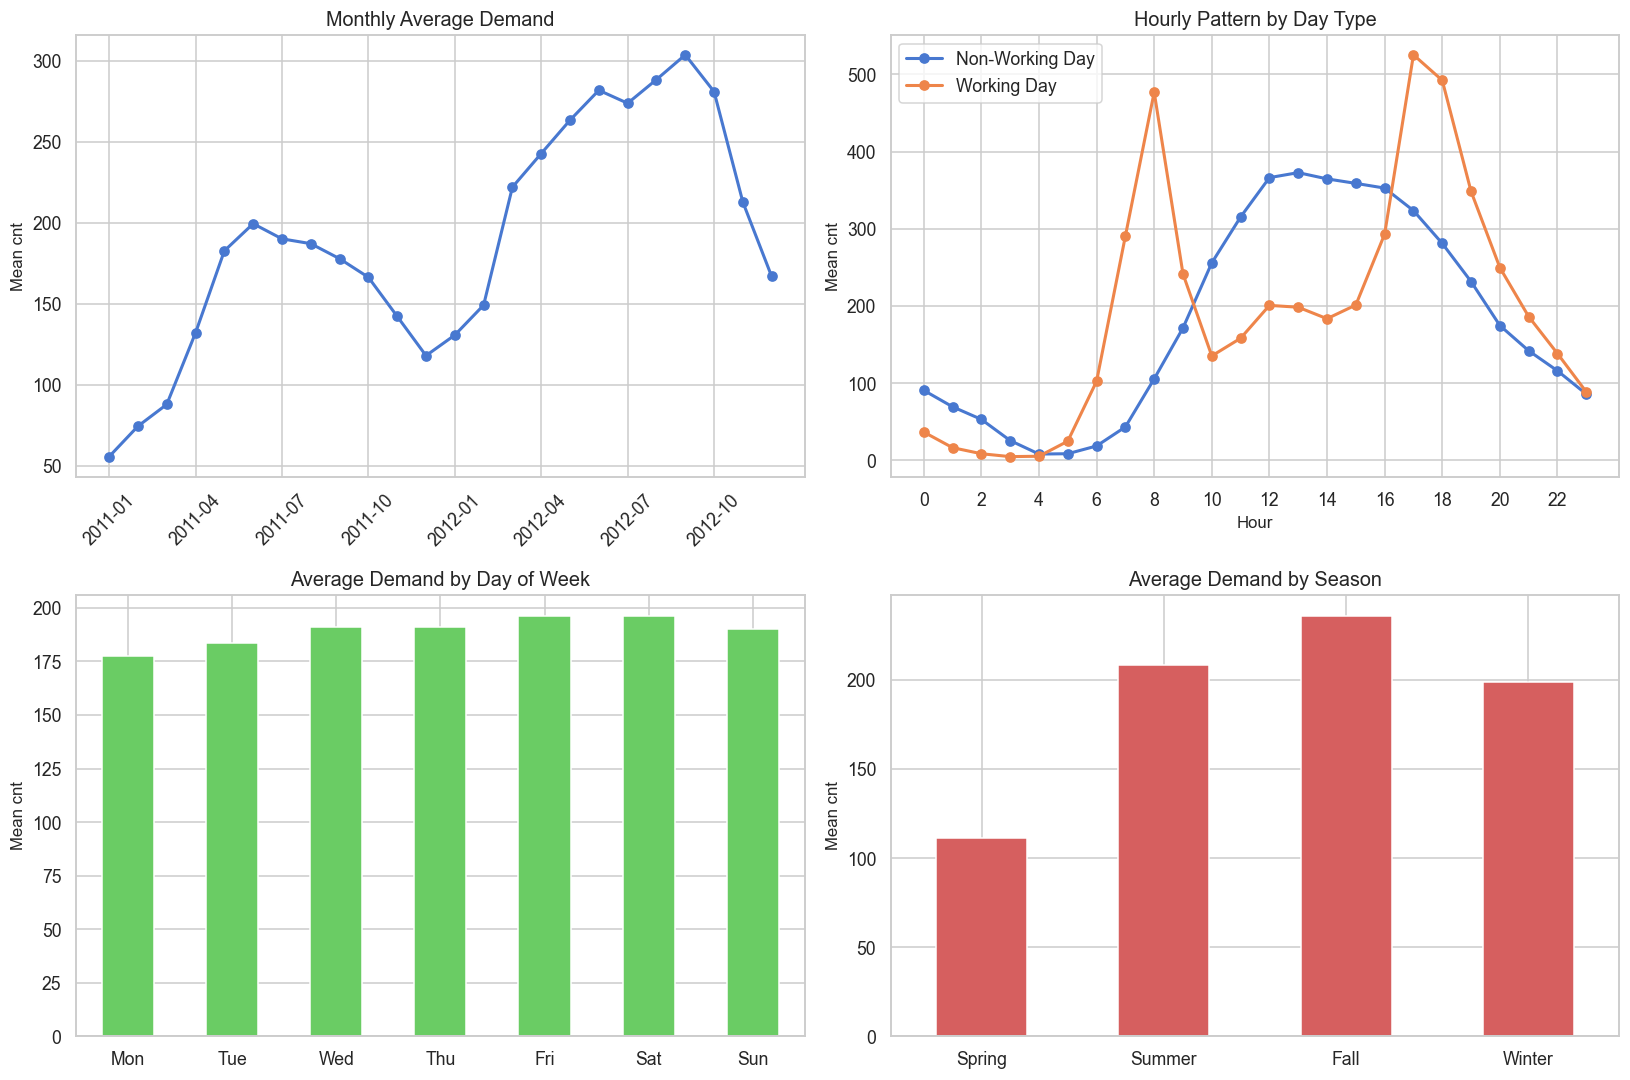

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 6a  Monthly trend
monthly = df.groupby(df["dteday"].dt.to_period("M"))[TARGET].mean()
monthly.index = monthly.index.astype(str)
axes[0, 0].plot(monthly.values, marker="o", lw=2, color=PALETTE[0])
axes[0, 0].set_xticks(range(0, len(monthly), 3))
axes[0, 0].set_xticklabels(monthly.index[::3], rotation=45)
axes[0, 0].set_title("Monthly Average Demand")
axes[0, 0].set_ylabel("Mean cnt")

# 6b  Hourly pattern — working vs non-working day
hourly = df.groupby(["hr", "workingday"])[TARGET].mean().unstack()
hourly.columns = ["Non-Working Day", "Working Day"]
hourly.plot(ax=axes[0, 1], marker="o", lw=2)
axes[0, 1].set_title("Hourly Pattern by Day Type")
axes[0, 1].set_xlabel("Hour")
axes[0, 1].set_ylabel("Mean cnt")
axes[0, 1].set_xticks(range(0, 24, 2))

# 6c  Day of week
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow = df.groupby("weekday")[TARGET].mean()
dow.index = dow_labels
dow.plot.bar(ax=axes[1, 0], color=PALETTE[2], edgecolor="white")
axes[1, 0].set_title("Average Demand by Day of Week")
axes[1, 0].set_ylabel("Mean cnt")
axes[1, 0].tick_params(axis="x", rotation=0)

# 6d  Season
season_avg = df.groupby("season")[TARGET].mean()
season_avg.index = [SEASON_MAP[i] for i in season_avg.index]
season_avg.plot.bar(ax=axes[1, 1], color=PALETTE[3], edgecolor="white")
axes[1, 1].set_title("Average Demand by Season")
axes[1, 1].set_ylabel("Mean cnt")
axes[1, 1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()

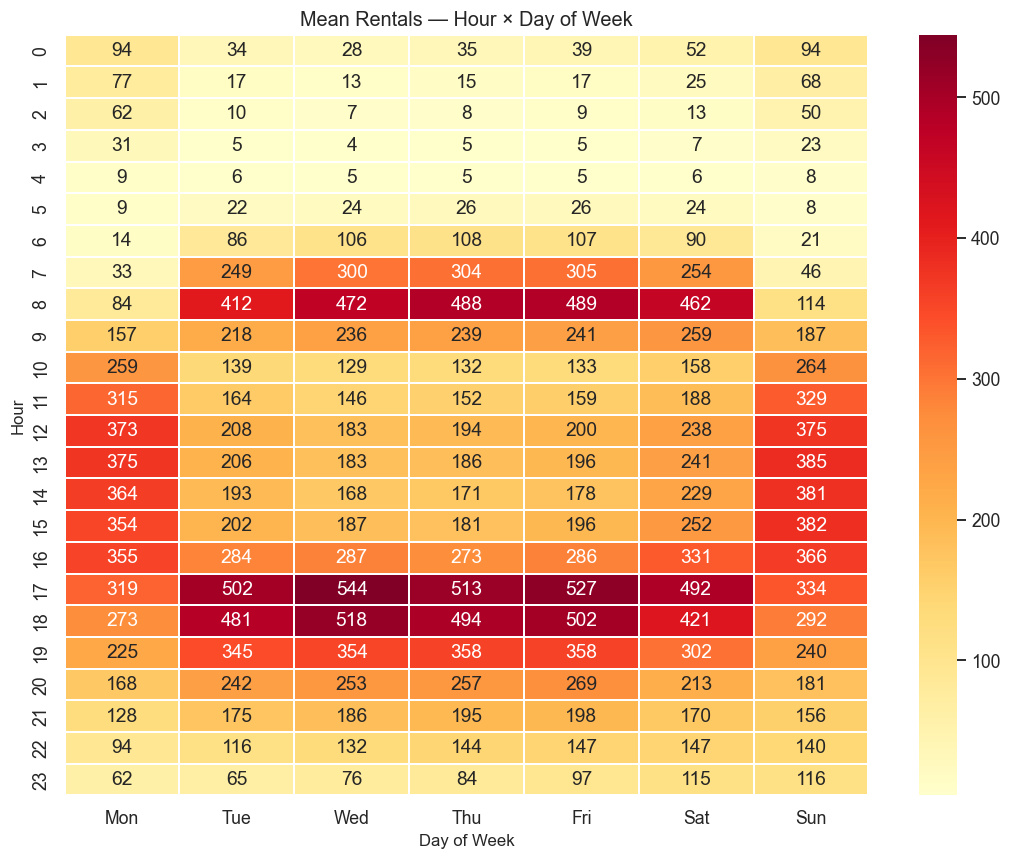

In [12]:
# 6e  Heatmap — hour × day of week
pivot = df.pivot_table(values=TARGET, index="hr", columns="weekday", aggfunc="mean")
pivot.columns = dow_labels

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pivot, cmap="YlOrRd", annot=True, fmt=".0f", linewidths=0.3, ax=ax)
ax.set_title("Mean Rentals — Hour × Day of Week")
ax.set_ylabel("Hour")
ax.set_xlabel("Day of Week")
plt.tight_layout()
plt.show()

---
## 7 — Correlation Analysis

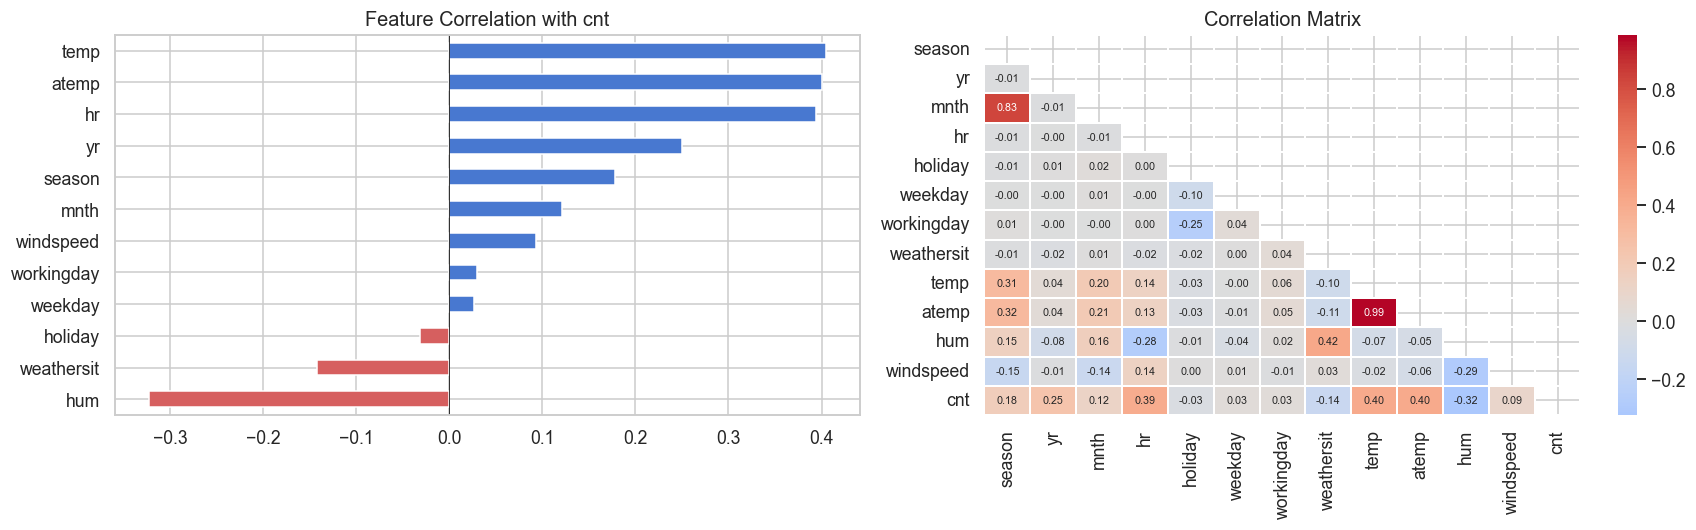

Top positive correlations with cnt:
temp      0.404772
atemp     0.400929
hr        0.394071
yr        0.250495
season    0.178056

Top negative correlations with cnt:
hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284


In [13]:
model_cols = [c for c in df.select_dtypes("number").columns if c not in LEAKAGE]
corr = df[model_cols].corr()

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_WIDE)

# 7a  Target correlation bar
target_corr = corr[TARGET].drop(TARGET).sort_values()
colors = [PALETTE[3] if v < 0 else PALETTE[0] for v in target_corr]
target_corr.plot.barh(ax=axes[0], color=colors, edgecolor="white")
axes[0].set_title(f"Feature Correlation with {TARGET}")
axes[0].axvline(0, color="black", lw=0.5)

# 7b  Full heatmap (lower triangle)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            center=0, ax=axes[1], annot_kws={"size": 7}, linewidths=0.3)
axes[1].set_title("Correlation Matrix")

plt.tight_layout()
plt.show()

print("Top positive correlations with cnt:")
print(target_corr.sort_values(ascending=False).head(5).to_string())
print("\nTop negative correlations with cnt:")
print(target_corr.head(5).to_string())

In [14]:
# 7c  Multicollinearity check
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.7:
            high_corr.append((corr.columns[i], corr.columns[j], round(corr.iloc[i, j], 3)))

if high_corr:
    print("Highly correlated feature pairs (|r| > 0.7):")
    for a, b, r in sorted(high_corr, key=lambda x: -abs(x[2])):
        print(f"  {a:12s} ↔ {b:12s}  r = {r:+.3f}")
    print("\n→ temp & atemp are nearly identical — drop one before modeling.")
else:
    print("No highly correlated pairs found.")

Highly correlated feature pairs (|r| > 0.7):
  temp         ↔ atemp         r = +0.988
  season       ↔ mnth          r = +0.830

→ temp & atemp are nearly identical — drop one before modeling.


---
## 8 — Outlier Analysis

In [15]:
# IQR-based outlier detection on key numeric features + target
outlier_cols = NUMERIC + [TARGET]
outlier_summary = []

for col in outlier_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary.append({
        "feature": col,
        "lower_bound": round(lower, 3),
        "upper_bound": round(upper, 3),
        "n_outliers": n_outliers,
        "pct": round(n_outliers / len(df) * 100, 2)
    })

pd.DataFrame(outlier_summary).set_index("feature")

,lower_bound,upper_bound,n_outliers,pct
feature,,,,
temp,-0.140,1.140,0,0.00
atemp,-0.099,1.053,0,0.00
hum,0.030,1.230,22,0.13
windspeed,-0.119,0.478,342,1.97
cnt,-321.500,642.500,505,2.91


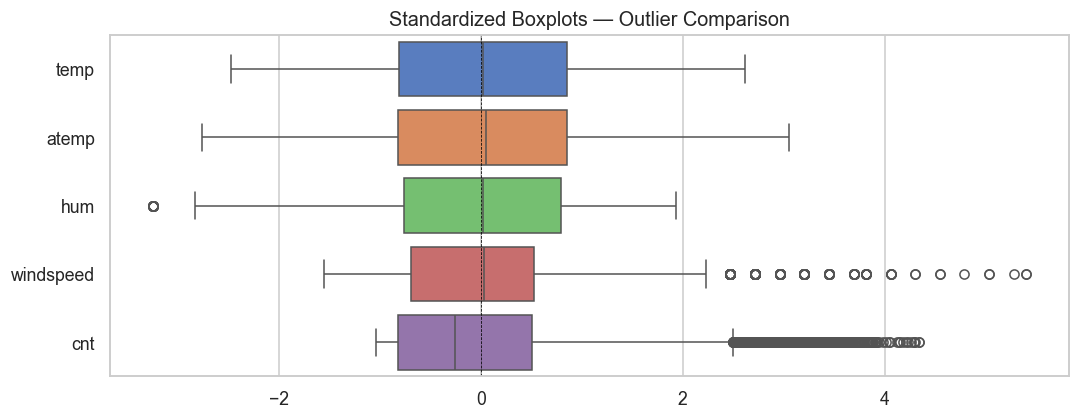

→ windspeed has notable right-tail outliers.
→ cnt outliers are legitimate high-demand hours — do not remove.


In [16]:
# Boxplots of numeric features (standardized for comparison)
fig, ax = plt.subplots(figsize=(10, 4))
df_std = (df[outlier_cols] - df[outlier_cols].mean()) / df[outlier_cols].std()
sns.boxplot(data=df_std, orient="h", palette="muted", ax=ax)
ax.set_title("Standardized Boxplots — Outlier Comparison")
ax.axvline(0, color="black", lw=0.5, ls="--")
plt.tight_layout()
plt.show()

print("→ windspeed has notable right-tail outliers.")
print("→ cnt outliers are legitimate high-demand hours — do not remove.")

---
## 9 — Feature Engineering Candidates

In [17]:
fe = df.copy()

# Cyclical encoding
fe["hr_sin"]   = np.sin(2 * np.pi * fe["hr"] / 24)
fe["hr_cos"]   = np.cos(2 * np.pi * fe["hr"] / 24)
fe["mnth_sin"] = np.sin(2 * np.pi * fe["mnth"] / 12)
fe["mnth_cos"] = np.cos(2 * np.pi * fe["mnth"] / 12)

# Derived binary features
fe["is_rush_hour"] = fe["hr"].isin([7, 8, 9, 17, 18, 19]).astype(int)
fe["is_weekend"]   = (fe["workingday"] == 0).astype(int)

# Interaction
fe["temp_x_hum"] = fe["temp"] * fe["hum"]

# Correlation of new features with target
new_feats = ["hr_sin", "hr_cos", "mnth_sin", "mnth_cos", "is_rush_hour", "is_weekend", "temp_x_hum"]
print("Engineered feature correlations with cnt:\n")
for f in new_feats:
    r = fe[f].corr(fe[TARGET])
    print(f"  {f:15s}  r = {r:+.3f}")

Engineered feature correlations with cnt:

  hr_sin           r = -0.410
  hr_cos           r = -0.408
  mnth_sin         r = -0.173
  mnth_cos         r = -0.195
  is_rush_hour     r = +0.454
  is_weekend       r = -0.030
  temp_x_hum       r = +0.072


---
## 10 — Summary & Modeling Recommendations

### Data Quality
- 17,379 hourly records, no missing values, no duplicates
- Covers 2 full years (2011–2012) at hourly granularity

### Target Variable
- Right-skewed (skew ≈ 1.27) — log transform recommended for linear models
- No invalid or implausible values; upper outliers are real peak-demand hours

### Key Predictive Features
| Feature | Correlation | Direction |
|---------|------------|----------|
| `hr` (hour) | +0.40 | Peak at rush hours |
| `temp` | +0.40 | Warmer → more rentals |
| `yr` | +0.25 | YoY growth (~64%) |
| `hum` | −0.32 | High humidity → fewer rentals |
| `weathersit` | −0.30 | Bad weather → fewer rentals |

### Key Patterns
- **Working days**: bimodal peaks at 8–9 AM and 5–7 PM (commuters)
- **Weekends**: single broad midday peak (leisure)
- **Seasons**: Fall > Summer > Winter > Spring
- **Weather**: clear weather demand is 2–3× adverse conditions

### Multicollinearity
- `temp` ↔ `atemp` (r = 0.99) — drop `atemp`

### Data Leakage
- `casual + registered = cnt` — **must exclude** both from features
- `instant` (row ID) and `dteday` (raw date) also excluded

### Feature Engineering
1. Cyclical encoding: `hr_sin/cos`, `mnth_sin/cos`
2. Binary indicators: `is_rush_hour`, `is_weekend`
3. Interactions: `temp × hum`
4. Lag features: previous hour/day demand (if time-series approach)

### Modeling Strategy
- **Validation**: time-based split (train ≤ mid-2012, test = late 2012)
- **Baseline**: Ridge / Lasso with engineered features
- **Primary**: XGBoost, LightGBM, Random Forest
- **Metrics**: MAE, RMSE, R²